<a href="https://colab.research.google.com/github/Tristant2005/ML-Projects-Master/blob/main/anime_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN Generation tutorial in tenserflow**

Using a Generative Adversarial Network to generate new anime faces
https://www.youtube.com/watch?v=HxD-M-jTmEA

In [ ]:
!pip install -q opendatasets

import opendatasets as od
import pandas as pd
from google.colab import files
files.upload()

od.download('https://www.kaggle.com/datasets/soumikrakshit/anime-faces') # insert ypu kaggle  username and key


Saving kaggle.json to kaggle.json


100%|██████████| 441M/441M [00:02<00:00, 185MB/s]


In [ ]:
# import modules
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

# tensor flow stuff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

# **Get the data**

In [ ]:
#Set directory of where to find all the data for the model
BASE_DIR = './anime-faces/data'

In [ ]:
#get all images and put them into the list 'image_paths'
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

In [ ]:
image_paths[:5]

['./anime-faces/data/14901.png',
 './anime-faces/data/20921.png',
 './anime-faces/data/19518.png',
 './anime-faces/data/11388.png',
 './anime-faces/data/10202.png']

In [ ]:
#remove unnecessary file that containst nothing
image_paths.remove('./anime-faces/data/data')

In [ ]:
len(image_paths)

21551

# **Visualize Data**

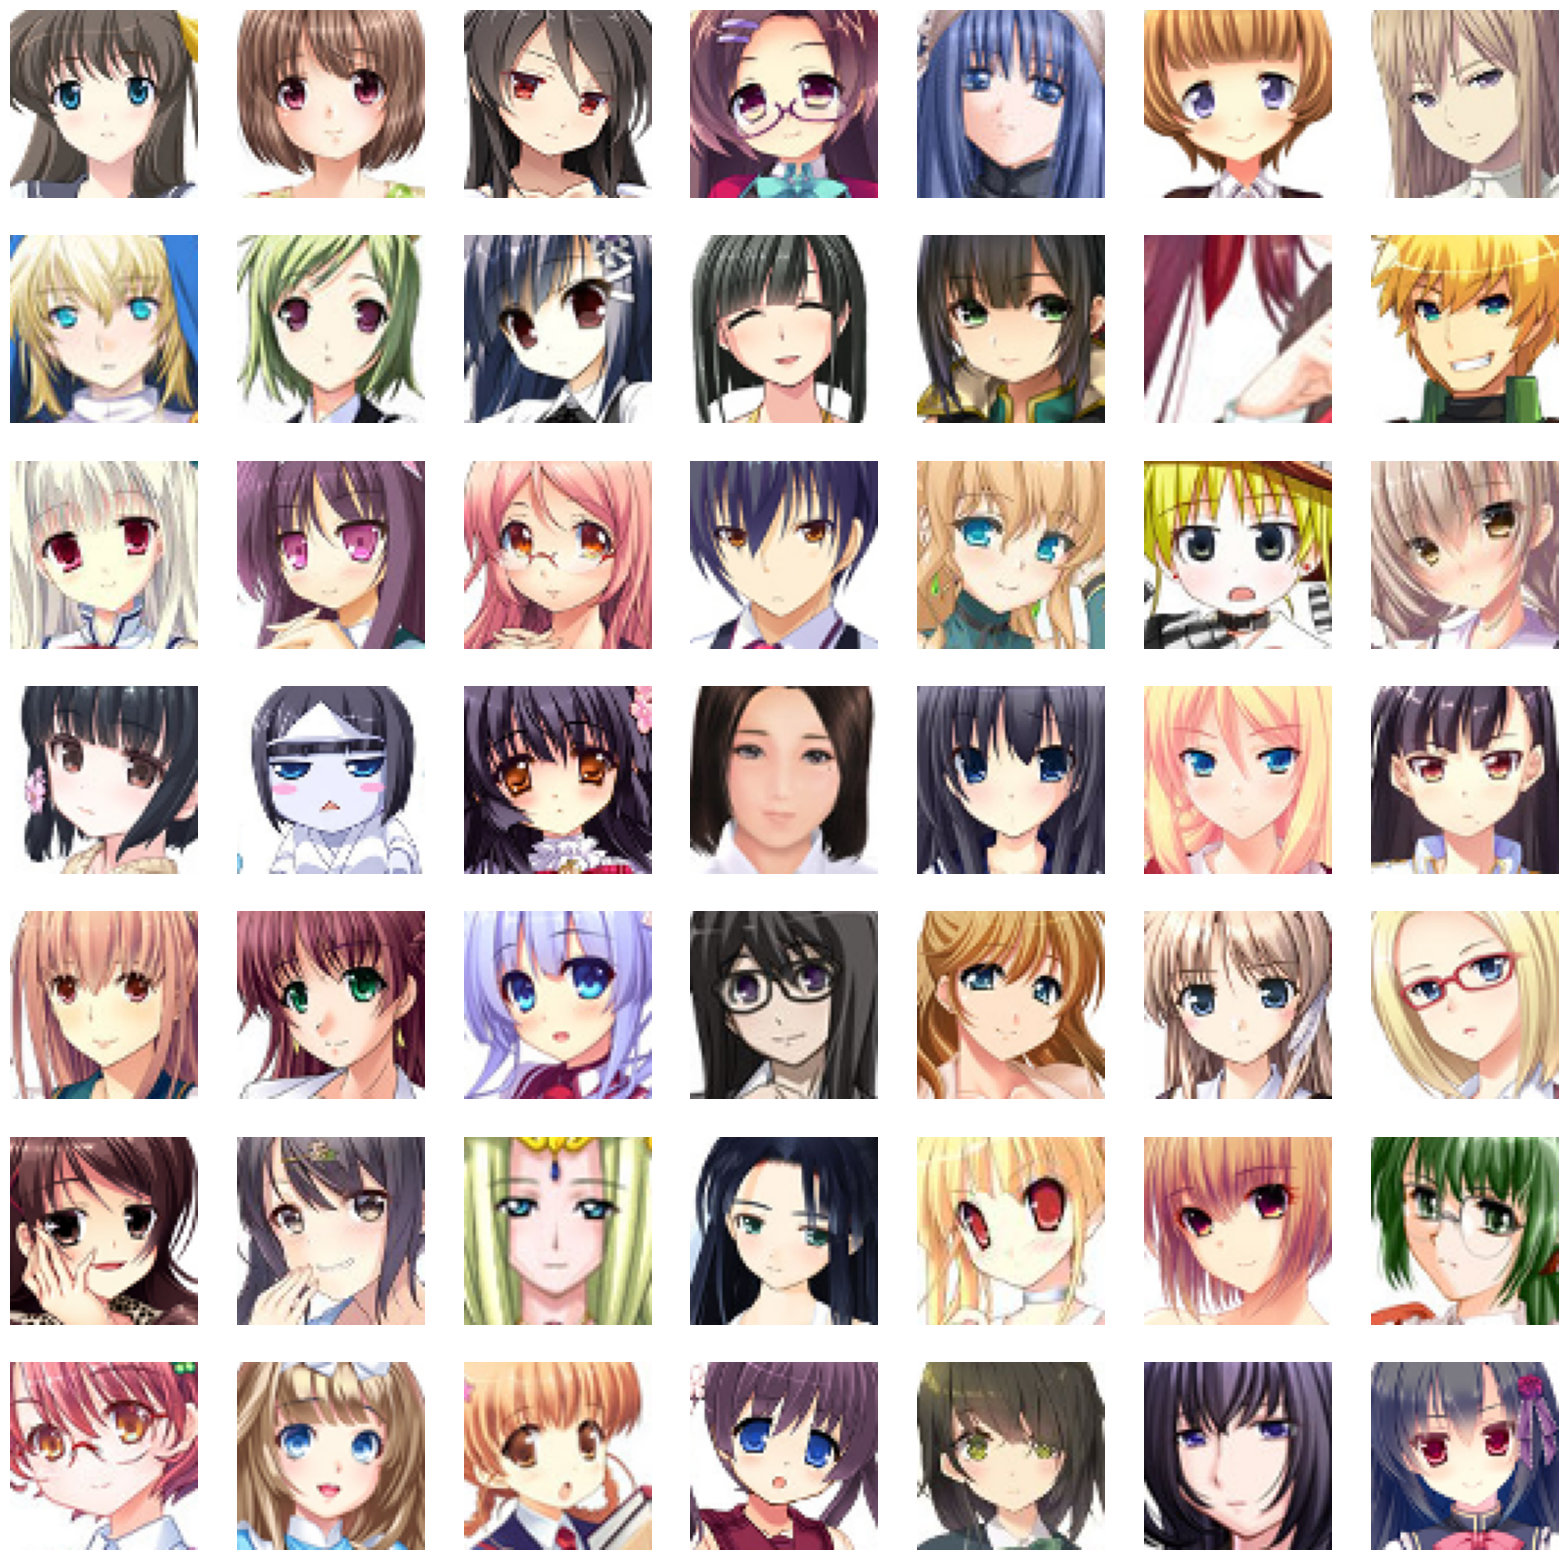

In [ ]:
#display images (7 x 7)
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49] #gets the first 49 images

index = 1 #not 0 because must be an integer with 1 <= num <= 49
for image_path in temp_images:
    plt.subplot(7, 7, index)

    #load image and convert to numpy array
    img = load_img(image_path)
    img = np.array(img)

    #show image
    plt.imshow(img)
    plt.axis('off')

    index += 1

# Preprocess images

In [ ]:
#Covert all images in training data into numpy arrays and append to list
#these images are what we will eventually throw into our model
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]

#convert the list of numpy arrays into a numpy array
train_images = np.array(train_images)

# Note:
# Tqdm is a popular Python library that provides a simple and convenient way to
# add progress bars to loops and iterable objects

  0%|          | 0/21551 [00:00<?, ?it/s]

In [ ]:
#check the shape of the images
train_images[0].shape

(64, 64, 3)

In [ ]:
#Reshape the array
#train_images.shape[0]: specifies the number of samples in the first dimension
#width = 64, height = 64, channels = 3 (R, G, B) (AKA. not gray scale)
#.astype('float32'): converts the data type of the array elements to 'float32'
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')

#now train_images is a four-dimensional shape [number_of_samples, height, width, channels]

#Note: Why do we do this?
#many machine learning frameworks expect input data to be in this format.
#particularly for tasks involving CNNs (convolutional neural networks),
#where the input needs to represent images with height, width, and channels.

In [ ]:
print(len(train_images))
print(train_images.shape[0])

21551
21551


In [ ]:
#Normalize images so that each images is represented by a float from -1 to 1

# Subtract 127.5 from each pixel value of the train_images array
# This centers the pixel values around 0 (since 127.5 is half of 255, the maximum pixel value)
train_images -= 127.5

# Divide each pixel value of the normalized_images array by 127.5
# This scales the pixel values so that they range from -1 to 1
train_images /= 127.5

# *Note*
# NumPy arrays support element-wise operations, meaning you can perform arithmetic operations
# directly on the array, and the operation will be applied to each element individually.

In [ ]:
# After normalization, each image in the train_images array has been transformed
# into a floating-point representation where pixel values range from -1 to 1.

# By converting the pixel values to floating-point numbers and normalizing them,
# the data is in a format that computational algorithms can work with effectively.
train_images[0]

array([[[0.99215686, 0.99215686, 0.9843137 ],
        [0.99215686, 0.9843137 , 0.9607843 ],
        [1.        , 1.        , 0.9607843 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.9529412 , 0.99215686, 1.        ],
        [0.9843137 , 1.        , 1.        ],
        [0.9843137 , 0.9843137 , 0.9843137 ],
        ...,
        [0.9529412 , 1.        , 0.9529412 ],
        [0.96862745, 1.        , 0.99215686],
        [0.99215686, 0.99215686, 1.        ]],

       [[0.9843137 , 1.        , 1.        ],
        [0.94509804, 0.9137255 , 0.8901961 ],
        [0.46666667, 0.39607844, 0.34901962],
        ...,
        [1.        , 0.9607843 , 1.        ],
        [1.        , 0.9843137 , 1.        ],
        [1.        , 1.        , 0.9764706 ]],

       ...,

       [[0.9372549 , 0.96862745, 0.9764706 ],
        [0.94509804, 0.9764706 , 0.9843137 ],
        [0.96862745, 1

# Create Generator & Descriminator Models

In [ ]:
#scale of random noise
LATENT_DIM = 100

#weigth initializer
#set weaights from -0.02 to +0.02
WEIGHT = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

#number of channels of image
#for or grey scale, keep as 1
CHANNELS = 3

### Generator Model

In [ ]:
#Make generator model
#Generator model will create new image like images in training data from random noise

#Sequential model is a linear stack of layers.
model = Sequential(name="generatorUwU")

#add random noise:
#make 1D random noise
#Adds a Dense layer to the model with 8x8x512 neurons.
#This layer will take a 1D random noise vector of size LATENT_DIM as input.
model.add(layers.Dense(8 * 8 * 512, input_dim = LATENT_DIM))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

#convert 1D random noise to 3D
model.add(layers.Reshape((8, 8, 512)))

#upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same", kernel_initializer=WEIGHT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

#upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=WEIGHT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

#upsample to 64x64 (target size)
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", kernel_initializer=WEIGHT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

#I don't even know what this does
model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

#get summary
generator = model
generator.summary()

Model: "generatorUwU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       524416    
 Transpose)                                           

### Descriminator Model

In [ ]:
#Make descriminator model
#Classifies the images from the generator as either "fitting in" or not with the data set
#If our generator model is good, we should always be fooling the descriminator model.

#Sequential model is a linear stack of layers.
model = Sequential(name="descriminatorOwO")
input_shape = (64, 64, 3)
#activation layer
alpha = 0.2

#create convolutional layers
#down sample images
#layer 1
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same", input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

#layer 2
model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same", input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

#layer 3
model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same", input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

#The Flatten layer is used to flatten the multi-dimensional
#output of the previous layer into a one-dimensional array.
model.add(layers.Flatten())

#Dropout is based. It's a regularization technique used to prevent overfitting
#in neural networks. In this case, 30% of the input units will be randomly dropped
model.add(layers.Dropout(0.3))

#output class
#This line of code adds a Dense layer to the model with one neuron and a sigmoid activation function.
#Output will either be 1 or 0.
#This type of layer is commonly used as the output layer in binary classification tasks.
model.add(layers.Dense(1, activation="sigmoid"))

#get summary
descriminator = model
descriminator.summary()

Model: "descriminatorOwO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)  

### Create DCGAN

In [ ]:
#Class for DCGAN (Deep Convolutional Generative Adversarial Networks).

class DCGAN(keras.Model):
    #constuctor
    def __init__(self, generator, descriminator, latent_dim):
        #initialize everything including models and metrics
        super().__init__()
        self.generator = generator
        self.descriminator = descriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    #compiles the model
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    #takes training data
    def train_step(self, real_images):
        #get batch size from data
        batch_size = tf.shape(real_images)[0]
        #generate random noise
        random_noise = tf.random.normal(shape=[batch_size, self.latent_dim])

        #train Descriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            #Loss is a measure of how wrong the model's predictions
            #are; when training we are trying to minimize loss.

            """ compute loss on real images """
            #define variables
            pred_real = self.descriminator(real_images, training=True)

            #Create real images lable
            #creates a tensorflow array with dimentions of batch size with all ones
            real_labels = tf.ones((batch_size, 1))

            #label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            """ compute loss on fake images """
            #define variables
            fake_images = self.generator(random_noise)
            pred_fake = self.descriminator(fake_images, training=True)

            #Create fake images lable
            #creates a tensorflow array with dimentions of batch size with all zeroes
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            #total descriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2


        #descriminator gradients:
        #compute descriminator gradients
        gradients = tape.gradient(d_loss, self.descriminator.trainable_variables)
        #update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.descriminator.trainable_variables))

        #train the generator model:
        #create the labels
        labels = tf.ones((batch_size, 1))
        #generator wants the descriminator to think that fake images are real
        with tf.GradientTape() as tape:
            #generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            #classify images as real or fake
            pred_fake = self.descriminator(fake_images, training=True)
            #compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        #generatos gradients:
        #compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        #update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        #update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss":self.d_loss_metric.result(), "g_loss":self.g_loss_metric.result()}


In [ ]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_images=25, latent_dim=100):
        self.num_images = num_images
        self.latent_dim = latent_dim

        #create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        #generate image from noise and denormalizing the image
        g_image = self.model.generator(self.noise)
        g_image = (g_image * 127.5) + 127.5

        g_image.numpy()

        fig = plt.figure(figsize=(8, 8))

        for i in range(self.num_images):
            plt.subplot(5, 5, i + 1)
            img = array_to_img(g_image[i])
            plt.imshow(img)
            plt.axis("off")

        # plt.savefig(f"epoch_{epoch}.png")
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save("generator.h5")


In [ ]:
#initialize the model
dcgan = DCGAN(generator=generator, descriminator=descriminator, latent_dim=LATENT_DIM)

In [ ]:
#set learing rates
D_LR = 0.0001
G_LR = 0.0003

#compile the model
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())


Epoch 1/5
673/674 [============================>.] - ETA: 0s - d_loss: 0.6288 - g_loss: 0.9729

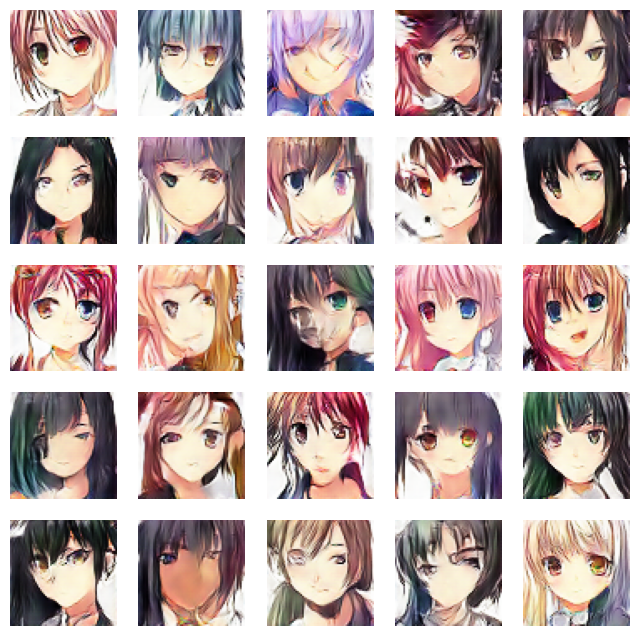

674/674 [==============================] - 42s 62ms/step - d_loss: 0.6289 - g_loss: 0.9725
Epoch 2/5
673/674 [============================>.] - ETA: 0s - d_loss: 0.6240 - g_loss: 0.9847

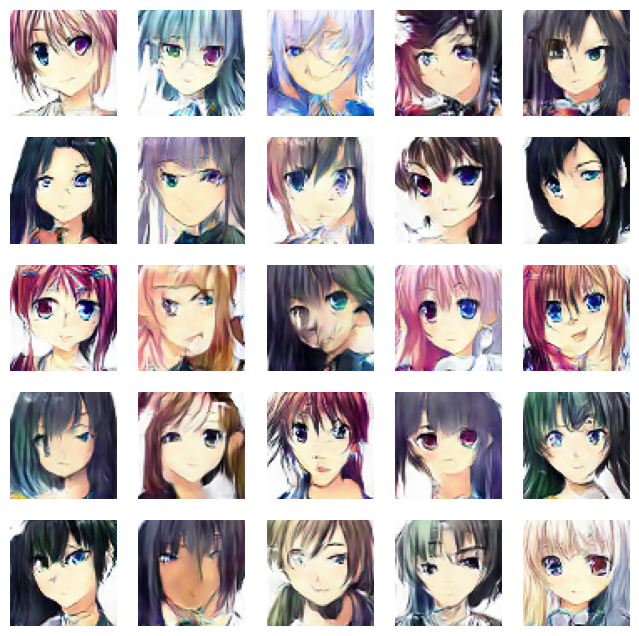

674/674 [==============================] - 44s 65ms/step - d_loss: 0.6241 - g_loss: 0.9843
Epoch 3/5
673/674 [============================>.] - ETA: 0s - d_loss: 0.6163 - g_loss: 1.0065

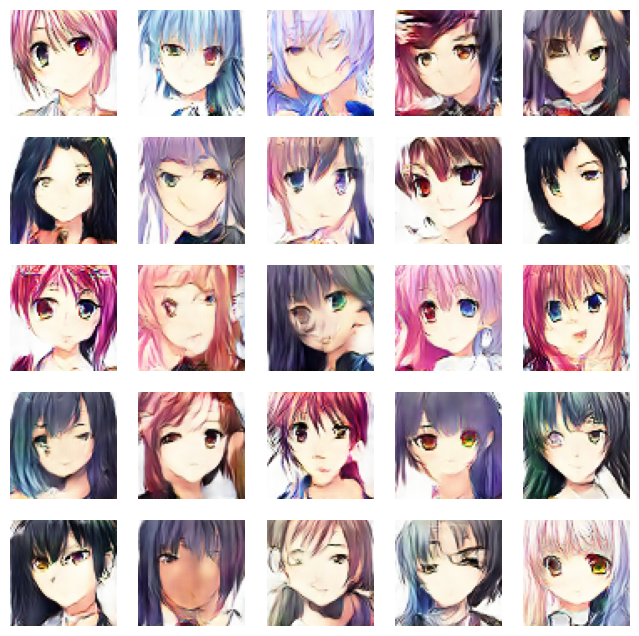

674/674 [==============================] - 44s 65ms/step - d_loss: 0.6162 - g_loss: 1.0069
Epoch 4/5
673/674 [============================>.] - ETA: 0s - d_loss: 0.6141 - g_loss: 1.0099

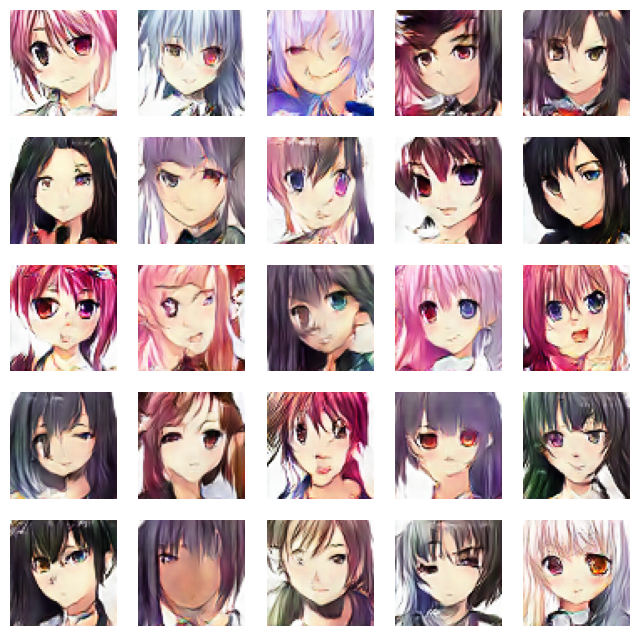

674/674 [==============================] - 44s 66ms/step - d_loss: 0.6141 - g_loss: 1.0094
Epoch 5/5
673/674 [============================>.] - ETA: 0s - d_loss: 0.6121 - g_loss: 1.0217

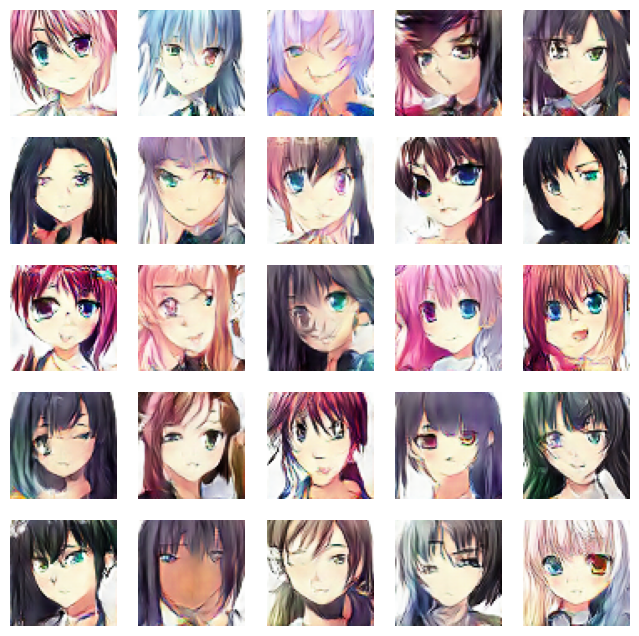

674/674 [==============================] - 45s 66ms/step - d_loss: 0.6122 - g_loss: 1.0222


Text(0, 0.5, 'generator_loss')

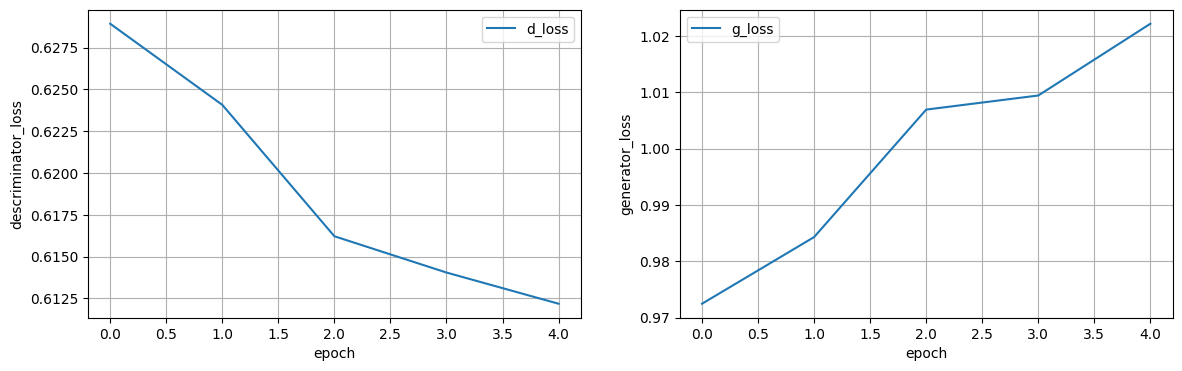

In [ ]:
N_EPOCHS = 5
history = dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

# plot learning rate curve and accuracy curve
fig,ax = plt.subplots(1,2,figsize=(14,4))

ax[0].plot(history.history['d_loss'],label='d_loss')

ax[1].plot(history.history['g_loss'],label='g_loss')
for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('epoch')
    ax[i].set_xlabel('epoch')
ax[0].set_ylabel('descriminator_loss')
ax[1].set_ylabel('generator_loss')

# print(history.history)

### Generate new image

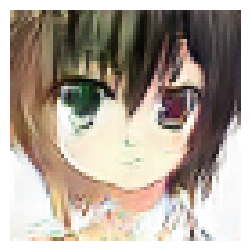

In [ ]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))

#generate image from noise and denormalizing the image
g_image = dcgan.generator(noise)
g_image = (g_image * 127.5) + 127.5

g_image.numpy()

img = array_to_img(g_image[0])
plt.imshow(img)
plt.axis("off")

# plt.savefig(f"epoch_{epoch}.png")
plt.show()

In [ ]:
plt.savefig(f"generated_image_mod1.png")